In [1]:
# Allow us to load `open_cp` without installing
import sys, os.path
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

## Simulate spatial locations

Work in progress...

# Resources for address data

The [TIGER/Line](https://www.census.gov/geo/maps-data/data/tiger-line.html) dataset from the US Census bureau provides a great resource for getting block-level address data.
- [Technical documentation](https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2016/TGRSHP2016_TechDoc.pdf)
- It is easiest to download the data from the [FTP Site](ftp://ftp2.census.gov/geo/tiger/TIGER2016/ADDRFEAT/)
- Here I link to the ADDRFEAT datasets which provide the best geocoding data, according to the tech documentation.
- The files are named using the [FIP County Code](https://en.wikipedia.org/wiki/FIPS_county_code).  For chicago this is 17031.
- Once downloaded, unzip, and find a standard shape file.  It is interesting to load this, and an extract of the crime data (e.g. by loading into a GeoDataFrame and saving), into QGIS and visualising the result.

It is also possible to extract address details from OpenStreetMap.  In particular, for Chicago, there are a very large number of individual buildings, with addresses, available.  However, I have also noticed that the OSM data is not as complete as the US Census dataset (for example, minor roads missing names, even when those roads appear in the crime dataset).

The Census data from 2013 seems good to use.  The 2016 data seems to be more "aggregated": it is easy to find examples of a single block which is split into, say, 3 paths in the geometry.  In the 2013 data each part will contain a range of addresses, while in the 2016 data, only one part contains all the addresses, the other parts having "None" as the address range.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import numpy as np
import pandas as pd

#filename = os.path.join("/media", "disk", "tl_2013_17031_edges", "tl_2013_17031_edges.shp")
filename = os.path.join("..", "..", "..", "..", "..", "Data", "tl_2013_17031_edges", "tl_2013_17031_edges.shp")

In [3]:
edges = gpd.read_file(filename)

In [4]:
# Slightly curious, if you look it up.  But lon/lat
edges.crs

{'init': 'epsg:4269'}

In [5]:
edges.ix[12]

ARTPATH                                                       N
COUNTYFP                                                    031
DECKEDROAD                                                    N
DIVROAD                                                       N
EXTTYP                                                        N
FEATCAT                                                       S
FULLNAME                                              N Park Dr
GCSEFLG                                                       N
HYDROFLG                                                      N
LFROMADD                                                   None
LTOADD                                                     None
MTFCC                                                     S1400
OFFSETL                                                       N
OFFSETR                                                       N
OLFFLG                                                        N
PASSFLG                                 

We only care about the columns "geometry" and "FULLNAME" (giving the road name) and LFROMADD, LTOADD, RFROMADD, RTOADD

In [6]:
want = {"geometry", "FULLNAME", "LFROMADD", "LTOADD", "RFROMADD", "RTOADD"}
edges = gpd.GeoDataFrame({key:edges[key] for key in want})
edges.crs={'init': 'epsg:4269'}
edges.head()

,FULLNAME,LFROMADD,LTOADD,RFROMADD,RTOADD,geometry
0,None,None,None,None,None,"LINESTRING (-87.60164199999998 41.845196, -87...."
1,None,None,None,None,None,LINESTRING (-87.11116199999998 42.149408999999...
2,None,None,None,None,None,"LINESTRING (-87.62505699999998 42.071528, -87...."
3,None,None,None,None,None,LINESTRING (-87.74845399999998 42.152859999999...
4,None,None,None,None,None,"LINESTRING (-87.63278799999999 41.970942, -87...."


In [7]:
import open_cp.sources.chicago as chicago

frame = chicago.load_to_geoDataFrame().dropna()

# Optionally project and round?

In [8]:
frame = frame.to_crs({'init': 'epsg:3435', "preserve_units":True})

In [9]:
edges = edges.to_crs({'init': 'epsg:3435', "preserve_units":True})

In [111]:
xcs = frame.geometry.map(lambda pt : pt.coords[0][0])
ycs = frame.geometry.map(lambda pt : pt.coords[0][1])
import shapely.geometry
import numpy as np
frame.geometry = [shapely.geometry.Point(np.round(x), np.round(y)) for x,y in zip(xcs, ycs)]

# Pick out one block

We'll eventually iterate over each block, but let's just pick one.

In [8]:
one = frame[frame.address == frame.address.unique()[0]].copy()
one.head()

,address,case,crime,geometry,location,timestamp,type
0,010XX N CENTRAL PARK AVE,HZ560767,OTHER OFFENSE,POINT (-87.71645415899999 41.899712716),APARTMENT,2016-12-22T02:55:00,VIOLATE ORDER OF PROTECTION
21374,010XX N CENTRAL PARK AVE,JA210311,THEFT,POINT (-87.716462854 41.899954256),VEHICLE NON-COMMERCIAL,2017-04-01T07:00:00,$500 AND UNDER
23295,010XX N CENTRAL PARK AVE,JA210493,ASSAULT,POINT (-87.71645193800001 41.899561771),STREET,2017-04-03T08:03:00,AGGRAVATED: HANDGUN
24540,010XX N CENTRAL PARK AVE,HZ342785,BATTERY,POINT (-87.716457119 41.899786826),RESIDENTIAL YARD (FRONT/BACK),2016-07-09T22:40:00,AGGRAVATED: HANDGUN
54066,010XX N CENTRAL PARK AVE,HZ259442,NARCOTICS,POINT (-87.716463039 41.899935047),ALLEY,2016-05-10T20:57:00,POSS: HEROIN(WHITE)


# Distances

In [9]:
def find_match_via_distance(point):
    dist = edges.geometry.distance(point)
    return edges.ix[dist.argmin]

def via_distance(one):
    return [ find_match_via_distance(point).name for point in one.geometry ]

one["edge_index"] = via_distance(one)
one.head()

,address,case,crime,geometry,location,timestamp,type,edge_index
0,010XX N CENTRAL PARK AVE,HZ560767,OTHER OFFENSE,POINT (-87.71645415899999 41.899712716),APARTMENT,2016-12-22T02:55:00,VIOLATE ORDER OF PROTECTION,164302
21374,010XX N CENTRAL PARK AVE,JA210311,THEFT,POINT (-87.716462854 41.899954256),VEHICLE NON-COMMERCIAL,2017-04-01T07:00:00,$500 AND UNDER,164302
23295,010XX N CENTRAL PARK AVE,JA210493,ASSAULT,POINT (-87.71645193800001 41.899561771),STREET,2017-04-03T08:03:00,AGGRAVATED: HANDGUN,164302
24540,010XX N CENTRAL PARK AVE,HZ342785,BATTERY,POINT (-87.716457119 41.899786826),RESIDENTIAL YARD (FRONT/BACK),2016-07-09T22:40:00,AGGRAVATED: HANDGUN,164302
54066,010XX N CENTRAL PARK AVE,HZ259442,NARCOTICS,POINT (-87.716463039 41.899935047),ALLEY,2016-05-10T20:57:00,POSS: HEROIN(WHITE),164302


# Intersections

In [10]:
def find_match_via_intersection(point):
    possibles = edges[edges.geometry.intersects( point.buffer(0.001) )]
    i = possibles.geometry.distance(point).argmin()
    return edges.ix[i]

def via_intersection(one):
    return [ find_match_via_intersection(point).name
        for point in one.geometry ]
    
one["edge_index1"] = via_intersection(one)
one.head()

,address,case,crime,geometry,location,timestamp,type,edge_index,edge_index1
0,010XX N CENTRAL PARK AVE,HZ560767,OTHER OFFENSE,POINT (-87.71645415899999 41.899712716),APARTMENT,2016-12-22T02:55:00,VIOLATE ORDER OF PROTECTION,164302,164302
21374,010XX N CENTRAL PARK AVE,JA210311,THEFT,POINT (-87.716462854 41.899954256),VEHICLE NON-COMMERCIAL,2017-04-01T07:00:00,$500 AND UNDER,164302,164302
23295,010XX N CENTRAL PARK AVE,JA210493,ASSAULT,POINT (-87.71645193800001 41.899561771),STREET,2017-04-03T08:03:00,AGGRAVATED: HANDGUN,164302,164302
24540,010XX N CENTRAL PARK AVE,HZ342785,BATTERY,POINT (-87.716457119 41.899786826),RESIDENTIAL YARD (FRONT/BACK),2016-07-09T22:40:00,AGGRAVATED: HANDGUN,164302,164302
54066,010XX N CENTRAL PARK AVE,HZ259442,NARCOTICS,POINT (-87.716463039 41.899935047),ALLEY,2016-05-10T20:57:00,POSS: HEROIN(WHITE),164302,164302


In [11]:
np.all(one.edge_index == one.edge_index1)

True

# Via rtree

We'll use an [R-Tree](https://en.wikipedia.org/wiki/R-tree).  Building the initial index takes a bit of time, but it's vastly quicker once you have the index.

In [12]:
import rtree

In [13]:
gap = 0.001

def gen():
    for i, row in edges.iterrows():
        bds = list(row.geometry.bounds)
        bds = [bds[0]-gap, bds[1]-gap, bds[2]+gap, bds[3]+gap]
        yield i, bds, None
        
idx = rtree.index.Index(gen())

In [24]:
def find_match_via_rtree(point):
    possibles = edges.ix[list(idx.intersection(point.coords[0]))]
    if len(possibles) == 0:
        #raise ValueError("Found no candidates for {}".format(point))
        from collections import namedtuple
        Error = namedtuple("Error", ["name"])
        return Error(name=-1)
    i = possibles.geometry.distance(point).argmin()
    return edges.ix[i]

def via_rtree(one):
    return [ find_match_via_rtree(point).name
        for point in one.geometry ]
    
one["edge_index2"] = via_rtree(one)
one.head()

,address,case,crime,geometry,location,timestamp,type,edge_index,edge_index1,edge_index2
0,010XX N CENTRAL PARK AVE,HZ560767,OTHER OFFENSE,POINT (-87.71645415899999 41.899712716),APARTMENT,2016-12-22T02:55:00,VIOLATE ORDER OF PROTECTION,164302,164302,164302
21374,010XX N CENTRAL PARK AVE,JA210311,THEFT,POINT (-87.716462854 41.899954256),VEHICLE NON-COMMERCIAL,2017-04-01T07:00:00,$500 AND UNDER,164302,164302,164302
23295,010XX N CENTRAL PARK AVE,JA210493,ASSAULT,POINT (-87.71645193800001 41.899561771),STREET,2017-04-03T08:03:00,AGGRAVATED: HANDGUN,164302,164302,164302
24540,010XX N CENTRAL PARK AVE,HZ342785,BATTERY,POINT (-87.716457119 41.899786826),RESIDENTIAL YARD (FRONT/BACK),2016-07-09T22:40:00,AGGRAVATED: HANDGUN,164302,164302,164302
54066,010XX N CENTRAL PARK AVE,HZ259442,NARCOTICS,POINT (-87.716463039 41.899935047),ALLEY,2016-05-10T20:57:00,POSS: HEROIN(WHITE),164302,164302,164302


In [15]:
all(one.edge_index1 == one.edge_index2)

True

In [16]:
%timeit(via_distance(one))

1 loop, best of 3: 36.4 s per loop


In [17]:
%timeit(via_intersection(one))

1 loop, best of 3: 26.7 s per loop


In [18]:
%timeit(via_rtree(one))

100 loops, best of 3: 14.3 ms per loop


## Check we always get the same result

In [17]:
for i in frame.index[100:200]:
    pt = frame.ix[i].geometry
    a = find_match_via_distance(pt).name
    b = find_match_via_intersection(pt).name
    c = find_match_via_rtree(pt).name
    assert a == b
    assert b == c

# Process the entire dataset

The procedure doesn't quite work, which is why the modification above to return "-1" on failure to find.

What is then amusing is that _all_ the failures occur at the airport, which in hindsight seems reasonable!

In [25]:
frame["edge_index"] = via_rtree(frame)

In [28]:
frame[frame.edge_index == -1].location.unique()

array(['AIRCRAFT', 'AIRPORT BUILDING NON-TERMINAL - SECURE AREA',
       'AIRPORT TERMINAL LOWER LEVEL - SECURE AREA',
       'AIRPORT TERMINAL UPPER LEVEL - SECURE AREA', 'OTHER',
       'AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA',
       'AIRPORT EXTERIOR - SECURE AREA',
       'AIRPORT EXTERIOR - NON-SECURE AREA', 'AIRPORT/AIRCRAFT',
       'AIRPORT PARKING LOT', 'AIRPORT VENDING ESTABLISHMENT'], dtype=object)

In [30]:
frame = frame[frame.edge_index != -1].copy()

In [35]:
lookup = pd.DataFrame({"case": frame.case, "edge":frame.edge_index})
lookup.head()

,case,edge
0,HZ560767,164302
1,HZ561134,208575
2,HZ565584,163466
3,HZ561772,87269
4,HZ561969,133687


In [36]:
lookup.to_csv("edge_lookup.csv")

# Some common issues found

- Sometimes the "edges" returned are not continuous.  This can be correct (e.g. two sides of multi-lane highway).  It can also be a "problem" in the sense that we miss a section of a block.  *Possible fix:* Decode the string "028XX N MIL..." to detect we want all numbers between 2800 and 2899.  Then fetch all these edges?
- Sometimes there is a genuine error in the data, and a coordinate doesn't match the claimed block at all.
- Sometimes there is a small "closest point error" on our part, and we accidently pick up an edge with a different name (or no name at all (e.g. an alleyway).  *Possible fix:* Let democracy decide upon the correct name; remove all edges which don't match; combine with 1st idea about to add other possible edges (this _will_ be needed); check for genuine outliers.

# Analyse the lookup

- '0000X E GRAND AVE' Seems to be an error?

- '028XX N MILWAUKEE AVE' is an example where the closest point method just gets it wrong.  Here it would be appropriate to then look at all the edges, select all those in the correct address range, and etc.

- '080XX S PULASKI RD' Nothing wrong, but we miss a part of the road (so again joni with all edges...)

- '020XX E 71ST ST'  A genuinely split road (east and west lanes).  We also pick up an "alley".  This could be discarded without issue.

- '026XX W NORTH AVE' In the "unbalanced aspect ratio" plot, the points don't match the edge.

In [8]:
lookup = pd.read_csv("edge_lookup.csv", names = ["case", "edge"], header=0)

# Make a lookup.  This breaks things for "HOMICIDE" crime, but we don't care.
l = dict()
for _, row in lookup.iterrows():
    l[row.case] = row.edge
lookup = l

In [403]:
block = frame.address.unique()[132]
block

'002XX E 116TH ST'

In [404]:
edge_ids = set()
for case in frame[frame.address == block].case:
    edge_ids.add(lookup[case])
edge_ids

{53732}

In [405]:
edges.ix[edge_ids]

,FULLNAME,LFROMADD,LTOADD,RFROMADD,RTOADD,geometry
53732,E 116th St,200,298,201,299,LINESTRING (-87.61794199999999 41.682576999999...


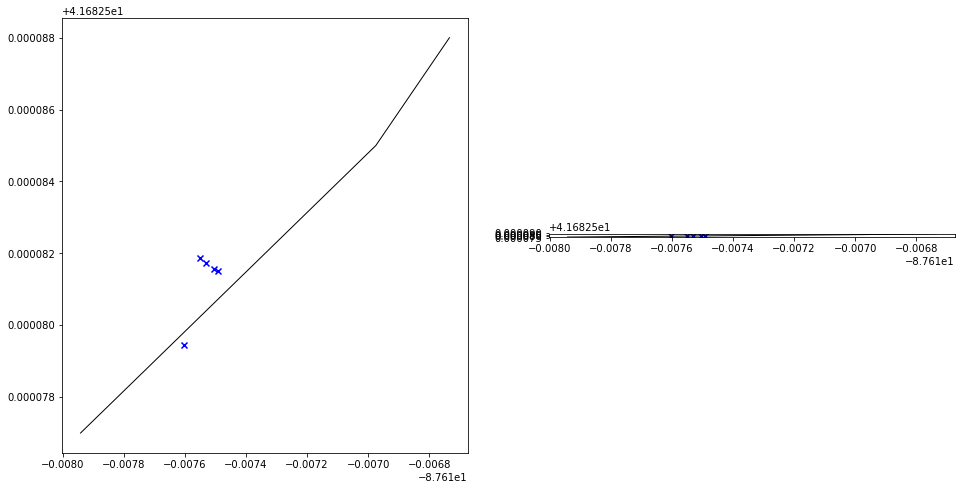

In [406]:
def get_xy(frame):
    x = frame.geometry.map(lambda pt : pt.coords[0][0])
    y = frame.geometry.map(lambda pt : pt.coords[0][1])
    return x, y

fig, axes = plt.subplots(ncols=2, figsize=(16,8))
for ax in axes:
    edges.ix[edge_ids].plot(ax=ax, color="black")
    ax.scatter(*get_xy(frame[frame.address == block]), color="blue", marker="x")
axes[1].set_aspect(1)
None